In [1]:
import numpy as np
np.seterr(all='raise')
import sys
sys.path.append('../')

from meshmaker.base import Base, Laziness
from meshmaker.model import Model
from meshmaker.mesh import Mesh
from meshmaker.pmesh import ParamMesh, MetaMesh, MetaScene
from meshmaker.meta import Railing, Stairs
from meshmaker.tform import TForm
from meshmaker.vec3 import vec3
from meshmaker.quat import quat
from meshmaker.loop import loops as Loops
from meshmaker.delaunay import triangulation
from meshmaker.planargraph import planargraph
from meshmaker.geometry import batch, slide, isnear, near, bbox, sintsxyp
from meshmaker.mgl import show, MainShader, EdgeShader, WireShader, LazyMaterials
from meshmaker.plt import *
from collections import defaultdict
from functools import partial, reduce
from itertools import cycle
import json

show = partial(show, programs=[MainShader(), EdgeShader(), WireShader(color=vec3.U(0.1))], background=vec3.U(0.5))

In [2]:
class Partition(Base):
    
    def __init__(self, *meshes, **kws):
        super().__init__(**kws)
        self.meshcount = 0
        self.meshes = []
        for mesh in meshes:
            self.av(mesh)

    def __iter__(self):
        """Yield the index, mesh pairs in the partition"""
        for i, mesh in enumerate(self.meshes):
            if mesh is not None:
                yield (i, mesh)
    
    def av(self, mesh, **kws):
        """Add new volume/vertex"""
        m = len(self.meshes)
        self.meshes.append(mesh)
        self.meshcount += 1
        return m
    
    def rv(self, v):
        """Remove volume/vertex v"""
        mesh = self.meshes[v]
        self.meshes[v] = None
        self.meshcount -= 1
        return mesh
    
    def sv(self, O, N, *vs):
        """Split vertices *vs using plane defined by O and N"""
        nvs = []
        for v in vs:
            v = self.rv(v)
            x, y = v.split(O, N)
            nvs.append(self.av(x))
            nvs.append(self.av(y))
        return nvs
    
    def graph(self, Interface=None):
        """Map the adjacency of volumes within the partition
        identifying the intersections of their bounding faces"""
        adjacent = defaultdict(lambda : defaultdict(lambda : {}))
        normals = {i: mesh.face_normals() for i, mesh in self}
        shell = getattr(self, '_shell', None)
        for i, u in self:
            for k, uF in u:
                uN = normals[i][k]
                uL = [u.vertices[x].cp() for x in uF]
                uL.reverse()
                for j, v in self:
                    if i < j:
                        continue
                    for l, vF in v:
                        vN = normals[j][l]
                        vL = [v.vertices[x].cp() for x in vF]
                        if uN.isnear(vN.fp()):
                            if isnear(uL[0].dot(uN), vL[0].dot(uN)):
                                overlap = Loops([uL]).intersect(Loops([vL]))
                                if overlap.loops:
                                    interior = not (i == shell or j == shell)
                                    support = dict(extent=overlap, interior=interior)
                                    if Interface is not None:
                                        support = Interface(**support)
                                    adjacent[i][j][k] = support
                                    adjacent[j][i][l] = support
        return adjacent
    
    def shell(self):
        """Add node for the exterior of the partition (do last if at all)"""
        shell = Mesh.Union(*filter(None, self.meshes)).fp()
        self._shell = self.av(shell)
        return self._shell
    
    @property
    def shelled(self):
        return getattr(self, '_shell', None)

In [3]:
class Interface(Base):
    """Represent the multi-surface interface of two nodes within a partition"""
    
    def __init__(self, extent=None, interior=True, margin=0.1):
        self.extent = extent
        if margin > 0:
            self.extent = self.extent.offset(margin)
        self.interior = interior
        self.supports = [Loops((e, )) for e in self.extent.loops]
        #self.supports = [s.offset(margin) for s in self.supports]
        self._designed = False

    def design(self, N, doors, windows, **kws):
        """One-time determination of design parameters for scene representation

        Each of self.supports can have 0+ windows/doors
        """
        if self._designed:
            return self
        else:
            self._designed = True
        
        vertical = not isnear(abs(N.z), 1)
        
        self.doorways = []
        self.windowways = []
        
        # collect the intersects of any holes with their parents
        # these are where inset portal bridges are required
        self.portals = Loops()
        
        for extent, support in zip(self.extent.loops, self.supports):
            
            # this shouldnt in general be true, but is window placement okay if it fails?
            assert len(support.loops) == 1
            
            for loop in support.loops:
                if vertical:
                    if doors:
                        door_cfg = doors.pop(0)
                        door = self.door(loop, **door_cfg)
                        embedded = support.embed(door, mode='clip')
                        if embedded:
                            self.portals.al(door)
                            self.doorways.append((door[0].cp(), door[1].cp()))
                        else:
                            doors.insert(0, door_cfg)
                    if not self.interior:
                        for window in self.windows(extent, w=0.6, h=0.8, s=0.4):
                            embedded = support.embed(window, mode='strict')
                            if embedded:
                                self.portals.al(window)
                                self.windowways.append((window[0].cp(), window[1].cp()))
        return self

    def ___borders(self, loop, dx, dy, X, Y):
        if dx > 0 and dy > 0:
            hole = [loop[0] + X * dx + Y * dy,
                    loop[1] - X * dx + Y * dy,
                    loop[2] - X * dx - Y * dy,
                    loop[3] + X * dx - Y * dy]
            borders = [(loop, (hole, ))]
        elif dx > 0 and dy == 0:
            left = [loop[0].cp(), loop[0] + X * dx,
                    loop[3] + X * dx, loop[3].cp()]
            right = [loop[1] - X * dx, loop[1].cp(),
                     loop[2].cp(), loop[2] - X * dx]
            borders = [(left, ()), (right, ())]            
        elif dx == 0 and dy > 0:
            top = [loop[3] - Y * dy, loop[2] - Y * dy,
                   loop[2].cp(), loop[3].cp()]
            bottom = [loop[0].cp(), loop[1].cp(),
                      loop[1] + Y * dy, loop[0] + Y * dy]
            borders = [(top, ()), (bottom, ())]
        elif dx == 0 and dy == 0:
            borders = []
        else:
            print(dx, dy)
            raise
        return borders
        
    def tiles(self, loop, chunk_w=1.01, chunk_h=1.01, max_nx=None, max_ny=None):
        """Chunk a rectangular space into a grid"""
        lw = loop[0].d(loop[ 1])
        lh = loop[0].d(loop[-1])
        nx = int(lw / chunk_w)
        ny = int(lh / chunk_h)
        nx = nx if max_nx is None else min(max_nx, nx)
        ny = ny if max_ny is None else min(max_ny, ny)
        X = (loop[ 1] - loop[0]).nrm()
        Y = (loop[-1] - loop[0]).nrm()
        dx = near((lw - nx * chunk_w) / 2, 0)
        dy = near((lh - ny * chunk_h) / 2, 0)
        positions = []
        if nx > 0 and ny > 0:
            for x in range(0, nx):
                x = x * chunk_w + dx
                for y in range(0, ny):
                    y = y * chunk_h + dy
                    positions.append(loop[0] + X * x + Y * y)
        return positions
        
        #if positions:
        #    assert (nx > 0 and ny > 0)
        #    return positions, self.borders(loop, dx, dy, X, Y)
        #else:
        #    return positions, [(loop, ())]
    
    @staticmethod
    def loopO(loop):
        zmin = min(p.z for p in loop)
        for i, (u, v) in enumerate(slide(loop, 2)):
            if isnear(u.z, zmin) and isnear(v.z, zmin):
                return i

    def door(self, support, w=0.2, h=0.3, s=0.1, x=0.5):
        o = self.loopO(support)
        support = support[o:] + support[:o]
        T = (support[1] - support[0]).nrm()
        u = support[0].lerp(support[1], x) - (T * (w / 2)) + vec3.Z(s)
        v = u + (T * w)
        door = [u, v, v + vec3.Z(h), u + vec3.Z(h)]
        
        # clip door to support and use as inset, like with the windows
        
        return door
    
    def windows(self, support, w=0.2, h=0.2, s=0.2):
        o = self.loopO(support)
        support = support[o:] + support[:o]
        W = support[ 1].d(support[0])
        H = support[-1].d(support[0])
        chunk_w, chunk_h = min(W, 1.2 * w), min(H, 1.2 * (h + s))
        positions = self.tiles(support, chunk_w, chunk_h)
        T = (support[1] - support[0]).nrm()
        windows = []
        for o in positions:
            window = [o + (T * ((chunk_w - w) / 2)) + vec3.Z(s)]
            window.append(window[0] + (T * w))
            window.append(window[1] + vec3.Z(h))
            window.append(window[0] + vec3.Z(h))
            windows.append(window)
        return windows

    
class Wall:
    
    def __init__(self, interfaces, wall_texture, portal_texture, rim_texture):
        self.interfaces = interfaces
        self.wall_texture = wall_texture
        self.portal_texture = portal_texture
        self.rim_texture = rim_texture
    
    @staticmethod
    def orientto(O, R):
        """Reverse the loops in R if R.N != O.N"""
        lN = O.N
        rN = R.N
        if not lN.isnear(rN):
            for l in R.loops:
                l.reverse()
            for l in R.holes:
                l.reverse()
        return R
    
    @staticmethod
    def alignto(O, R):
        """Translate R along O.N until coplanar"""
        if R.loops:
            lN = O.N
            dN = O.loops[0][0]
            dN = lN * (O.loops[0][0].dot(lN) - R.loops[0][0].dot(lN))
            if not isnear(dN.dot(dN), 0):
                for l in R.loops:
                    dN.trnps(l)
                for l in R.holes:
                    dN.trnps(l)
                return R

    def __call__(self, control, faces):
        assert len(faces) == 1
        meshes = defaultdict(list)

        host = [control.vertices[v] for v in control.faces[faces[0]]]
        host = Loops((host, ))

        extents = Loops()
        for interface in self.interfaces:
            portals = self.orientto(host, interface.portals.cp())
            aligned = self.alignto(host, portals.cp())
            if aligned:
                for i, j in zip(portals.loops, aligned.loops):
                    mesh = Mesh()
                    mesh.bridge(j, i)
                    meshes[self.portal_texture].append(mesh)                
            #else:
            #    aligned = portals
            
            for support in interface.supports:
                assert (len(support.loops) == 1)
                
                support = self.orientto(host, support.cp())
                aligned = self.alignto(host, support)
                support = support if aligned is None else aligned

                try:
                    mesh = Mesh()
                    py = ([p.quant() for p in support.loops[0]],
                         [[p.quant() for p in l] for l in support.holes])
                    mesh.apy(py, 0.0001, None)
                    meshes[self.wall_texture].append(mesh)                
                except:
                    print('fuck it inner')
                    print((py, ))

            extent = self.orientto(host, interface.extent.cp())
            aligned = self.alignto(host, extent)
            extent = extent if aligned is None else aligned
            for e in extent.loops:
                extents.al(e)
        
        try:
            mesh = Mesh()
            #py = ([p.quant() for p in host.loops[0]],
            #     [[p.quant() for p in l] for l in extents.loops])
            
            outer = Loops((host.loops[0], ))
            for hole in extents.loops:
                outer.embed(hole, mode='clip')
            if near(outer.area, 0, 0.1) > 0:
            
                py = ([p.cp() for p in outer.loops[0]],
                     [[p.cp() for p in l] for l in outer.holes])
                
                mesh.apy(py, 0.0001, None)
                meshes[self.rim_texture].append(mesh)                
        except:
            print('fuck it outer')
            print((py, ))
            raise

        # DO THIS IN A WALL CLASS MAYBE?
        # compute inset bridge for each loop in self.portals.loops
        # mesh from the extent to each first/only loop of self.supports
        # mesh from each first/only loop of self.supports to associated portals
        
        return TForm(models=[Model(meshes=meshes)])


def show_graph(nodes, edges):
    """Represent topology of a graph of mesh nodes"""
    # nodes is a dict of (int, mesh) pairs
    # edges is a list of (i, j) int pairs, indices in nodes
    meshes = defaultdict(list)
    for i, node in nodes.items():
        cube = Mesh.cube_mesh(0.1)
        vec3.com(node.vertices).trnps(cube.vertices)
        meshes['generic_8'].append(cube)
    def wires(tf, nodes=None, edges=None):
        wires = []
        for i, j in edges:
            wires.append((vec3.com(nodes[i].vertices),
                          vec3.com(nodes[j].vertices)))
        return wires        
    meshes[next(meshes.keys().__iter__())][0].wires =\
        partial(wires, nodes=nodes, edges=edges)
    return TForm(models=[Model(meshes=meshes)])


texturecycle = cycle((f'generic_{i}' for i in range(8, 14)))
nexttex = lambda : next(texturecycle)


class Stairs(MetaMesh):
    
    def scene(self):
        pass


def scaffold(node, doorways, zmin_step=0.3):
    zmin = min([p.z for p in node.vertices])
    ncom = vec3.com(node.vertices)
    rims = []
    for u, v in doorways:
        if u.z - zmin < zmin_step:
            continue
        N = (v - u).crs(vec3.Z()).nrm()
        if ncom.dot(N) - u.dot(N) < 0:
            u, v = v, u
            N = N.fp()
        rims.append((u, v))
    for u, v in rims:
        T = (v - u).nrm()
        N = T.crs(vec3.Z())
        u = u - (T * 0.1) + (N * 0.1)
        v = v + (T * 0.1) + (N * 0.1)
        x, y = v + (N * 1.6), u + (N * 1.6)
        platform = [v, u, y, x]
        node.af(platform, meta='generic_3')


def show_partition(partition, doors={}, windows={}, wallwidth=0.1):
    adjacent = partition.graph(partial(Interface, margin=wallwidth))
    shell = partition.shelled
    
    #ptexture = 'generic_18' if self.interior else 'generic_15'
    ptexture = nexttex()
    rtexture = nexttex()
    nodes = {}
    for i in adjacent:
        ntexture = nexttex()
        nodes[i] = partition.meshes[i].cp().fp()
        nodes[i].offset(-wallwidth * 0 if i == shell else -wallwidth)
        doorways = []
        for k, face in nodes[i]:
            interfaces = []
            for j in adjacent[i]:
                if k in adjacent[i][j]:
                    iface = adjacent[i][j][k]
                    
                    N = nodes[i].face_normals()[k]
                    idoors = doors.get((i, j), doors.get((j, i), []))
                    iwindows = windows.get((i, j), windows.get((j, i), []))                    
                    interfaces.append(iface.design(N, idoors, iwindows))
                    doorways.extend(iface.doorways)

            wall = Wall(interfaces, ntexture, ptexture, rtexture)
            wall.__name__ = f'metawall-<{i},{k}>'
            nodes[i].meta[k] = wall

        scaffold(nodes[i], doorways)
        #stairs = Stairs(doorways)
    
    edges = [(i, j) for i in adjacent for j in adjacent[i]]

    mr = TForm(metas=[MetaMesh(node) for i, node in nodes.items()])
    mr.add(show_graph(nodes, edges))
    ms = MetaScene(mr)
    return ms

In [4]:
def cclean(self):
    if self.holes:
        print('CLEAN ME', self)

        cleaned = self.__class__(self.loops)
        for hole in self.holes:
            cleaned.embed(hole, mode='clip')
        self.loops = cleaned.loops
        self.holes = cleaned.holes

In [4]:
# how to frame the information of a "wall"
# 1+ interfaces, each with 0+ support Loops
# even if the rim of a support is modified, the wall which meshes
# the space between the supports needs to only mesh up to the support boundary...

# ergo, need a separate repr for the supports extend, separate from the rep
# which can be clipped to add doorways

In [4]:
X, Y, Z = vec3.X(), vec3.Y(), vec3.Z()
wallwidth = 0.1
door = dict(w=0.8, h=1.4, s=0.0)

control = Mesh.cube_mesh()

vec3.U(0.5).sclps(vec3.Z(1).trnps(control.vertices))

p = Partition()
x = p.av(control)

doors = defaultdict(list)
windows = defaultdict(list)

w, x = p.sv(vec3.X(0.25), X, x)

n_floors = 2
floors = []
for s in vec3.O().line(vec3.Z(), n_floors - 1):
    x, y = p.sv(s, Z, x)
    floors.append(y)
else:
    floors.append(x)

for i in range(1, n_floors):
    floors[i], new = p.sv(vec3.Y(0.25), Y, floors[i])
    doors[(floors[i], new)].append(door)

for i, f in enumerate(floors):
    doors[(w, f)].append(door)

shell = p.shell()
doors[(w, shell)].append(door)

R = 6
H = len(floors) * 2
S = vec3(R, R, H)
for m in filter(None, p.meshes):
    S.sclps(m.vertices)

ms = show_partition(p, doors, windows, wallwidth)
show(ms)

clip self to hole
clip self to hole
clip self to hole
clip self to hole
clip self to hole
clip self to hole
clip self to hole
clip self to hole
clip self to hole
clip self to hole
clip self to hole
clip self to hole
clip self to hole
clip self to hole
clip self to hole
clip self to hole
clip self to hole
clip self to hole
clip self to hole
clip self to hole
clip self to hole
clip self to hole
clip self to hole
clip self to hole
clip self to hole
clip self to hole
clip self to hole
clip self to hole
clip self to hole
clip self to hole
clip self to hole
Loaded texture: generic_13 (../resources/textures/generics/generic_13.png)
Loaded texture: generic_11 (../resources/textures/generics/generic_11.png)
Loaded texture: generic_12 (../resources/textures/generics/generic_12.png)
Loaded texture: generic_10 (../resources/textures/generics/generic_10.png)
Loaded texture: generic_3 (../resources/textures/generics/generic_3.png)
Loaded texture: generic_8 (../resources/textures/generics/generic_8.p

#
# like the quad face of a mesh class, have a subclass
# which supports apy analog for loops object
# 
# this can offer an optimized triangulation strategy while
# skipping the complicated polygon operations to construct
# a stupid delaunay triangulation input
# 

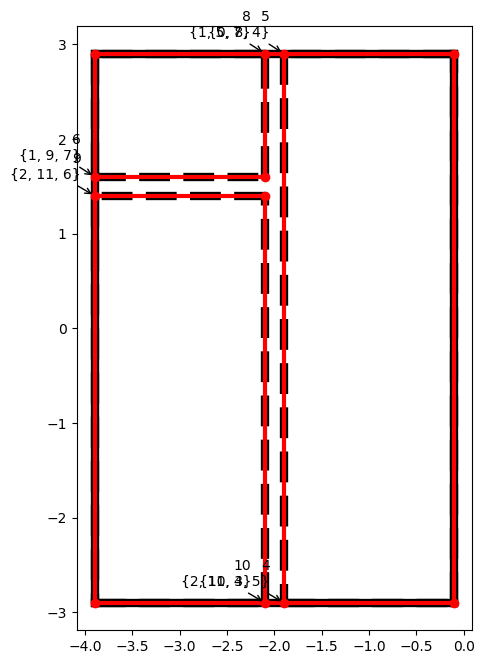

In [6]:
def triangulate_loops(self):
    
    pg = planargraph(loops=(self.loops + self.holes))
    loops = pg.loops()
    
    f, ax = plot()
    ax.set_aspect(1)
    self.plot(ax, lw=6)
    plot_pg(ax, pg, col='r')


pos = [
    [vec3(-0.1000, 2.9000, 1.6000), vec3(-3.9000, 2.9000, 1.6000), vec3(-3.9000, -2.9000, 1.6000), vec3(-0.1000, -2.9000, 1.6000)]
]
neg = [
    [vec3(-1.9000, -2.9000, 1.6000), vec3(-0.1000, -2.9000, 1.6000), vec3(-0.1000, 2.9000, 1.6000), vec3(-1.9000, 2.9000, 1.6000)],
    [vec3(-3.9000, 1.6000, 1.6000), vec3(-2.1000, 1.6000, 1.6000), vec3(-2.1000, 2.9000, 1.6000), vec3(-3.9000, 2.9000, 1.6000)],
    [vec3(-3.9000, 1.4000, 1.6000), vec3(-3.9000, -2.9000, 1.6000), vec3(-2.1000, -2.9000, 1.6000), vec3(-2.1000, 1.4000, 1.6000)]
]

ll = Loops(pos, neg)
triangulate_loops(ll)

In [7]:
def example_metas():
    a = vec3.O(   ).ring(5, 4, True)
    b = vec3.Z(1.0).ring(5, 4, True)
    c = vec3.Z(1.0).ring(4, 4, True)
    d = vec3.Z(0.9).ring(5, 4, True)
    e = vec3.Z(0.9).ring(4, 4, True)
    
    tex = ParamMesh.textured(texture='generic_4')

    mesh = Mesh()
    mesh._railings = []
    mesh._stairs = []


    bot = mesh.af(a, meta=tex)
    top = mesh.apy((b, (c, )), meta=tex)
    mesh.apy((d[::-1], (e[::-1], )), meta=tex)
    mesh.bridge(d, b)
    mesh.bridge(c, e)

    sup = mesh.perimeter(top)[1]
    mesh._railings.extend(sup)
    mesh._stairs.append((bot, sup[0]))
    mesh._stairs.append((bot, sup[2]))


    ground = MetaMesh(mesh)
    stairs = Stairs(mesh)
    railing = Railing(mesh)
    return [ground, stairs, railing]

m = example_metas()
r = TForm(metas=m)
ms = MetaScene(r)
show(ms)

AttributeError: 'NoneType' object has no attribute 'parent'

In [ ]:
r = 4
control = Mesh.cube_mesh(r)
p = Partition()
x = p.av(control)
x, y = p.sv(vec3.Z(1), vec3.Z(), x)
x, z = p.sv(vec3.Z(1), vec3.X(), x)
w, z = p.sv(vec3.Z(1), vec3.Y(), z)
y, a = p.sv(vec3.Z(1), vec3.U().xy().nrm(), y)
p.rv(w)
p.rv(y)
p.shell()
ms = show_partition(p)
show(ms)

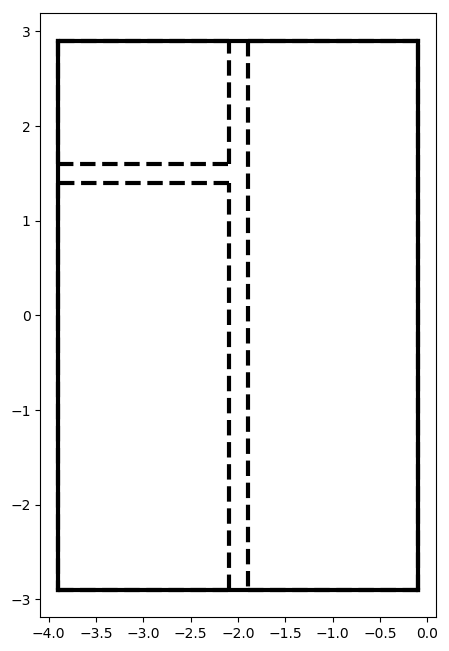

In [33]:
from meshmaker.geometry import loop_normal

#py = ([vec3(-3.0000, -3.0000, 2.0000), vec3(-3.0000, -3.0000, 0.0000), vec3(-3.0000, 3.0000, 0.0000), vec3(-3.0000, 3.0000, 2.0000)], [[vec3(-3.0000, 2.6500, 1.8500), vec3(-3.0000, 1.8500, 1.8500), vec3(-3.0000, 1.8500, 0.8500), vec3(-3.0000, 2.6500, 0.8500)], [vec3(-3.0000, 1.9000, 1.8500), vec3(-3.0000, 1.1000, 1.8500), vec3(-3.0000, 1.1000, 0.8500), vec3(-3.0000, 1.9000, 0.8500)], [vec3(-3.0000, 1.1500, 1.8500), vec3(-3.0000, 0.3500, 1.8500), vec3(-3.0000, 0.3500, 0.8500), vec3(-3.0000, 1.1500, 0.8500)], [vec3(-3.0000, 0.4000, 1.8500), vec3(-3.0000, -0.4000, 1.8500), vec3(-3.0000, -0.4000, 0.8500), vec3(-3.0000, 0.4000, 0.8500)], [vec3(-3.0000, -0.3500, 1.8500), vec3(-3.0000, -1.1500, 1.8500), vec3(-3.0000, -1.1500, 0.8500), vec3(-3.0000, -0.3500, 0.8500)], [vec3(-3.0000, -1.1000, 1.8500), vec3(-3.0000, -1.9000, 1.8500), vec3(-3.0000, -1.9000, 0.8500), vec3(-3.0000, -1.1000, 0.8500)], [vec3(-3.0000, -1.8500, 1.8500), vec3(-3.0000, -2.6500, 1.8500), vec3(-3.0000, -2.6500, 0.8500), vec3(-3.0000, -1.8500, 0.8500)]])
#py = ([vec3(1.6000, -2.9000, 7.9000), vec3(2.9000, -2.9000, 7.9000), vec3(2.9000, -2.9000, 0.1000), vec3(1.6000, -2.9000, 0.1000)], [[vec3(1.6500, -2.9000, -0.4000), vec3(2.8500, -2.9000, -0.4000), vec3(2.8500, -3.7000, -0.4000), vec3(1.6500, -3.7000, -0.4000)]])
#py = ([vec3(1.6000, -2.9000, 7.9000), vec3(2.9000, -2.9000, 7.9000), vec3(2.9000, -2.9000, 0.1000), vec3(1.6000, -2.9000, 0.1000)], [[vec3(1.6500, -2.9000, -0.4000), vec3(2.8500, -2.9000, -0.4000), vec3(2.8500, -3.7000, -0.4000), vec3(1.6500, -3.7000, -0.4000)]])
#py = ([vec3(1.6000, -2.9000, 7.9000), vec3(2.9000, -2.9000, 7.9000), vec3(2.9000, -2.9000, 0.1000), vec3(1.6000, -2.9000, 0.1000)], [[vec3(1.6500, -2.9000, -0.4000), vec3(2.8500, -2.9000, -0.4000), vec3(2.8500, -3.7000, -0.4000), vec3(1.6500, -3.7000, -0.4000)]])
#py = ([vec3(1.4000, 2.9000, 1.9000), vec3(1.4000, 2.9000, 0.1000), vec3(1.4000, -2.9000, 0.1000), vec3(1.4000, -2.9000, 1.9000)], [[vec3(1.4000, 0.4000, 0.1000), vec3(1.4000, -0.4000, 0.1000), vec3(1.4000, -0.4000, 1.7000), vec3(1.4000, 0.4000, 1.7000)]])

#py = ([vec3(2.0000, 3.0000, -1.5000), vec3(0.0000, 3.0000, -1.5000), vec3(0.0000, -3.0000, -1.5000), vec3(2.0000, -3.0000, -1.5000)],
#    [[vec3(0.0000, 0.4000, -1.5000), vec3(0.0000, -0.4000, -1.5000), vec3(1.6000, -0.4000, -1.5000), vec3(1.6000, 0.4000, -1.5000)]])

#l1 = [[vec3(1.5000, 8.0000, -1.5000), vec3(-3.0000, 8.0000, -1.5000), vec3(-3.0000, 6.0000, -1.5000), vec3(1.5000, 6.0000, -1.5000)]]
#l2 = [[vec3(1.5000, 8.0000, -1.5000), vec3(-3.0000, 8.0000, -1.5000), vec3(-3.0000, 6.0000, -1.5000), vec3(-1.1500, 6.0000, -1.5000), vec3(-1.1500, 7.6000, -1.5000), vec3(-0.3500, 7.6000, -1.5000), vec3(-0.3500, 6.0000, -1.5000), vec3(1.5000, 6.0000, -1.5000)]]

#py = ([vec3(1.4000, -2.9000, 1.9000), vec3(1.4000, -2.9000, 0.1000), vec3(-2.9000, -2.9000, 0.1000), vec3(-2.9000, -2.9000, 1.9000)],
#     [[vec3(1.4000, -2.9000, 1.9000), vec3(1.4000, -2.9000, 0.1000), vec3(-2.9000, -2.9000, 0.1000), vec3(-2.9000, -2.9000, 1.9000)]])

#py = ([vec3(-2.9000, 1.4000, 4.1000), vec3(-2.9000, -2.9000, 4.1000), vec3(1.4000, -2.9000, 4.1000), vec3(1.4000, 1.4000, 4.1000)], [[vec3(-2.8500, 1.3500, 4.1000), vec3(-2.8500, -2.8500, 4.1000), vec3(1.3500, -2.8500, 4.1000), vec3(1.3500, 1.3500, 4.1000)], [vec3(-2.8500, 1.3500, 4.1000), vec3(-2.8500, -2.8500, 4.1000), vec3(1.3500, -2.8500, 4.1000), vec3(1.3500, 1.3500, 4.1000)]])

py = ([vec3(-0.1000, 2.9000, 1.6000), vec3(-3.9000, 2.9000, 1.6000), vec3(-3.9000, -2.9000, 1.6000), vec3(-0.1000, -2.9000, 1.6000)], [[vec3(-1.9000, -2.9000, 1.6000), vec3(-0.1000, -2.9000, 1.6000), vec3(-0.1000, 2.9000, 1.6000), vec3(-1.9000, 2.9000, 1.6000)], [vec3(-3.9000, 1.6000, 1.6000), vec3(-2.1000, 1.6000, 1.6000), vec3(-2.1000, 2.9000, 1.6000), vec3(-3.9000, 2.9000, 1.6000)], [vec3(-3.9000, 1.4000, 1.6000), vec3(-3.9000, -2.9000, 1.6000), vec3(-2.1000, -2.9000, 1.6000), vec3(-2.1000, 1.4000, 1.6000)]])

#q = quat.uu(loop_normal(py[0]), vec3.Z())
#q.rot(py[0])
#for h in py[1]:
#    q.rot(h)

#for h in py[1]:
#    quat.av(-np.pi / 2, vec3.Y()).rot(h)

lp = Loops.from_polygon(py[0], py[1])

f, ax = plot()
ax.set_aspect(1)
lp.plot(ax)

#plot_loop(ax, py[0])
#for h in py[1]:
#    plot_loop(ax, h)

#for h in l1:
#    plot_loop(ax, h, col='b')
#for h in l2:
#    plot_loop(ax, h, col='g')
    
#plot_loop(ax, [vec3(1.5000, 8.0000, -1.5000), vec3(-3.0000, 8.0000, -1.5000), vec3(-3.0000, 6.0000, -1.5000), vec3(-1.1500, 6.0000, -1.5000), vec3(-1.1500, 7.6000, -1.5000), vec3(-0.3500, 7.6000, -1.5000), vec3(-0.3500, 6.0000, -1.5000), vec3(1.5000, 6.0000, -1.5000)], col='g')

# TODO: support layers/groups for showing/hiding meshes in mgl window 

In [ ]:
a = Mesh.cube_mesh()
b = Mesh.cube_mesh()
vec3.U(-0.5).trnps(a.vertices)
vec3.U( 0.5).trnps(b.vertices)
show(TForm(models=[Model(meshes={'generic_11': [a], 'generic_10': [b]})]))
#show([a, b])

In [ ]:
show(a.union(b))
show(b.union(a))
show(a.difference(b))
show(b.difference(a))
show(a.intersect(b))
show(b.intersect(a))